In [156]:
import pandas as pd
import json
import matplotlib as plt


In [157]:

with open("experiments.json") as f:
    data = json.load(f)


 ## Results analysis
 This is an interactive python file in VSCode. See [their support](https://code.visualstudio.com/docs/python/jupyter-support-py) for how this works

 Goal: Analyse the results from my experiments. More precisely, get a view on the lateness distribution of messages depending on the rate of transmission

In [158]:
offset_keys = [k for k in data.keys() if k.startswith("L-")]
offset_keys

stages = list(range(0, 6))

for k in offset_keys:
    df = pd.DataFrame(data[k])
    # plt.figure()
    # df.plot.hist(bins=range(0,10))
    print(df[0].value_counts())


0     499
11      1
Name: 0, dtype: int64
0      496
153      1
155      1
156      1
157      1
      ... 
332      1
333      1
334      1
335      1
246      1
Name: 0, Length: 493, dtype: int64
0    492
Name: 0, dtype: int64
0    249
Name: 0, dtype: int64
0      13107
1       1742
2        197
3         54
4         25
5         18
6          5
12         4
13         4
16         4
8          4
10         3
7          3
9          2
28         2
43         2
11         2
34         2
63         2
22         2
94         2
41         2
14         2
75         1
122        1
137        1
27         1
57         1
35         1
51         1
25         1
17         1
391        1
163        1
38         1
119        1
79         1
39         1
31         1
15         1
390        1
126        1
46         1
30         1
44         1
101        1
85         1
45         1
37         1
29         1
21         1
84         1
183        1
76         1
Name: 0, dtype: int64
0    493
Name: 0

In [159]:
def counter_to_df(data, counter_name) -> pd.DataFrame:
    return pd.DataFrame.from_dict(
        {k.split(".")[0]: int(data[k]) for k in data if counter_name in k},
        columns=[counter_name],
        orient="index",
    )


# grab keys, crop type away then create indexed DF and give column a fitting name
ooo = counter_to_df(data, "ooo")
total = counter_to_df(data, "total")
max = counter_to_df(data, "max")
ooi = counter_to_df(data, "ooi")



In [160]:

# build a big df that contains all the sessions data
counter_big_df = (
    ooi.join(total, how="outer")
    .join(max, how="outer")
    .join(ooo, how="outer")
    .fillna(0)
    .astype("int64")
)
#   .assign(ooo_percentage = lambda df: round(df["ooo"] / df["total"] * 100, 2))\
#   .assign(ooi_percentage = lambda df: round(df["ooi"] / df["total"] * 100, 2))\


In [163]:

# sum the different sessions values to get more data to look at for the 6 different nth styles
# loop over stages
sums = []
for stage in range(0, 6):
    filter_substring = f":{stage}"
    indexes = [f for f in counter_big_df.index if filter_substring in f]

    sums.append(counter_big_df[counter_big_df.index.isin(indexes)].sum())

counter_sums_df = (
    pd.DataFrame(sums)
    .assign(ooo_percentage=lambda df: round(df["ooo"] / df["total"] * 100, 2))
    .assign(ooi_percentage=lambda df: round(df["ooi"] / df["total"] * 100, 2))
    .drop(["ooi", "total", "max", "ooo"], axis=1)
    .assign(message_interval_in_sec=pd.Series(["2s", "1s", "1/2s", "1/10s", "1/50s", "1/100s"]))
)
# counter_sums_df
# counter_sums_df.plot.bar()


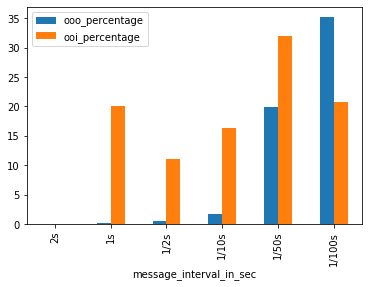

In [165]:
counter_sums_df.plot.bar(x="message_interval_in_sec", y=["ooo_percentage", "ooi_percentage"])



 okay so we now have a nice graph. What does it show? Well, out of index happens
 rather quickly. But the OOO take precedence over OOI (the code only allows one or the other and OOO takes precedence).
 Hence, starting at 1/10s, OOO rises and therefore, OOI goes down (in fact, most messages are likely OOO and OOI)

 But I want a distribution *how* late the messages come in.
 that way one can make intelligent decisions to day "waiting N messages captures 99% of all messages when given TX rate Y"
 ## Offset distributions calculation

In [211]:

def list_to_counted_offsets(name, list) -> pd.DataFrame():
    """
    converts a raw list of offsets 
    """
    return (pd.Series(list, name="abs")
        .value_counts()
        .to_frame()
        .assign(total=len(list))
        .assign(perc=lambda df: df["abs"]/df["total"])
        .drop(["abs", "total"], axis=1)
        .rename(columns={"perc": name})
    )


#build a 
just_lists = {k.split(".")[0]: data[k] for k in data if "offs" in k}
counts_dfs = [list_to_counted_offsets(k, just_lists[k]) for k in just_lists]

counts_dfs[23]

# return pd.DataFrame.from_dict(, columns=[list_name], orient="index")

#list_to_counted_offsets(ds_name, data)
#offset_count_dfs = pd.concat(lists_to_df(data, "offs"))


,L-20200218-04:4
0,0.954135
1,0.035673
2,0.005300
3,0.001223
4,0.000544
6,0.000476
5,0.000476
7,0.000408
11,0.000272
14,0.000204


In [214]:
# now we have the percentage of each offset "magnitude" for each experiment. 
# pandas allows joins on indexes (it's the default actually)
# so all I need to do is to use a reduce function to outer join all df's together on the indexes
from functools import reduce
distributions_df = reduce(lambda a, b: a.join(b, how="outer"), counts_dfs).fillna(0)
distributions_df


,L-20200219-01:1,L-20200219-13:1,L-20200218-13:1,L-20200219-06:0,L-20200219-11:5,L-20200218-19:1,L-20200219-18:0,L-20200219-14:2,L-20200218-20:2,L-20200217-23:5,...,L-20200218-07:1,L-20200218-17:5,L-20200218-06:0,L-20200218-02:2,L-20200219-20:2,L-20200219-08:2,L-20200218-08:2,L-20200219-15:3,L-20200219-00:0,L-20200219-16:4
0,0.998,0.502024,1.0,1.0,0.861113,1.0,1.0,0.998974,0.997938,0.921302,...,1.0,0.852269,1.0,1.0,1.0,0.500511,0.994845,0.497974,1.0,0.929977
1,0.000,0.001012,0.0,0.0,0.114447,0.0,0.0,0.001026,0.002062,0.068491,...,0.0,0.122747,0.0,0.0,0.0,0.000000,0.005155,0.001620,0.0,0.057126
2,0.000,0.001012,0.0,0.0,0.012943,0.0,0.0,0.000000,0.000000,0.001355,...,0.0,0.015910,0.0,0.0,0.0,0.000511,0.000000,0.001013,0.0,0.007771
3,0.000,0.001012,0.0,0.0,0.003548,0.0,0.0,0.000000,0.000000,0.000361,...,0.0,0.003630,0.0,0.0,0.0,0.000511,0.000000,0.000304,0.0,0.001901
4,0.000,0.001012,0.0,0.0,0.001642,0.0,0.0,0.000000,0.000000,0.000339,...,0.0,0.001573,0.0,0.0,0.0,0.000511,0.000000,0.000203,0.0,0.001075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4936,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000101,0.0,0.000000
4937,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000101,0.0,0.000000
4938,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000101,0.0,0.000000
4939,0.000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000101,0.0,0.000000


 The graph shows how the data follows a long tail distribution when looking at "stage 5" (the highest rate of TX)
 but a rather boring view when looking at a simple distribution

log axis on y
loglog axes, showing exponential values better


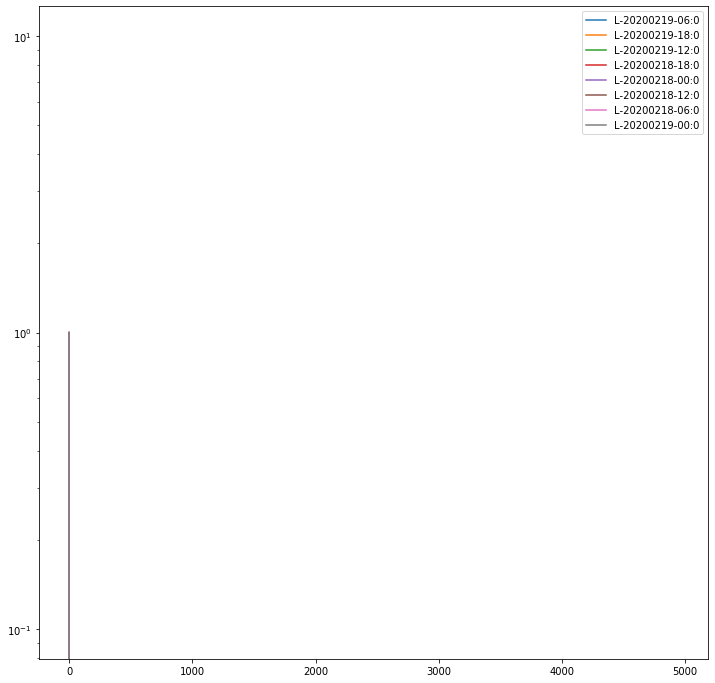

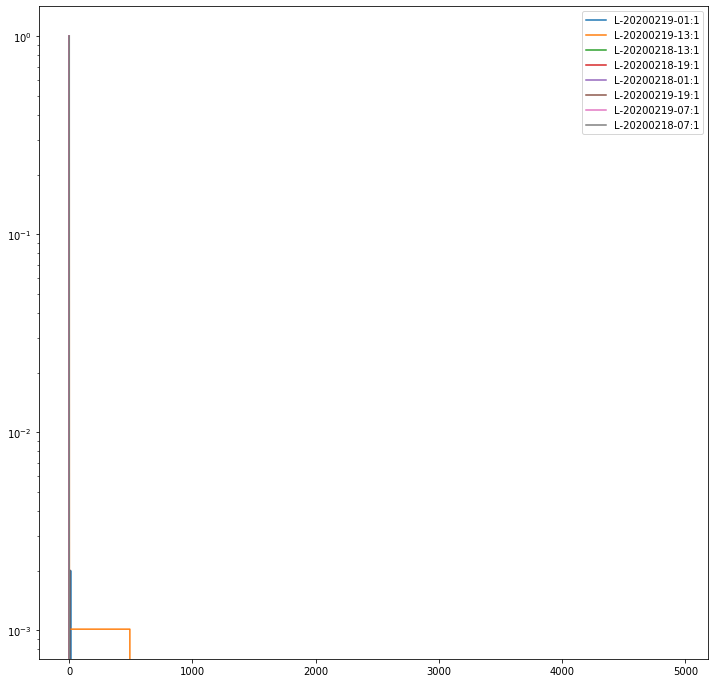

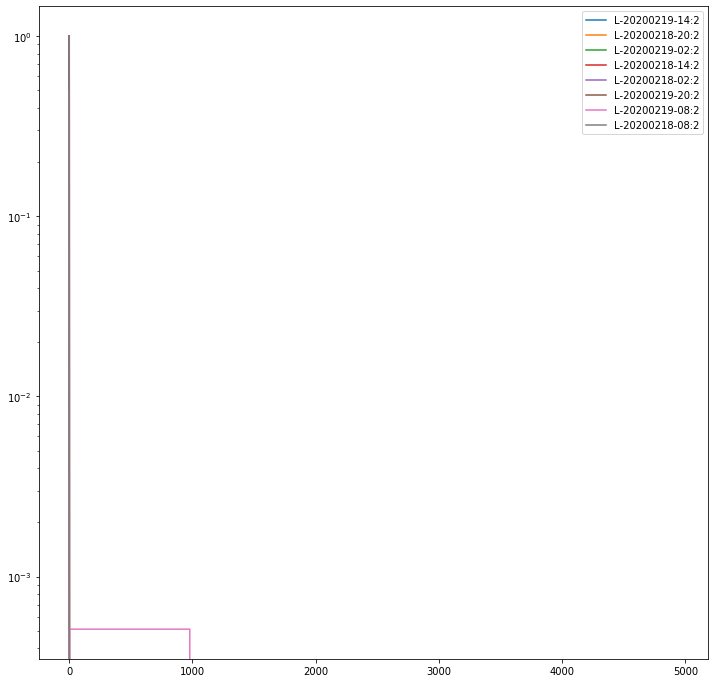

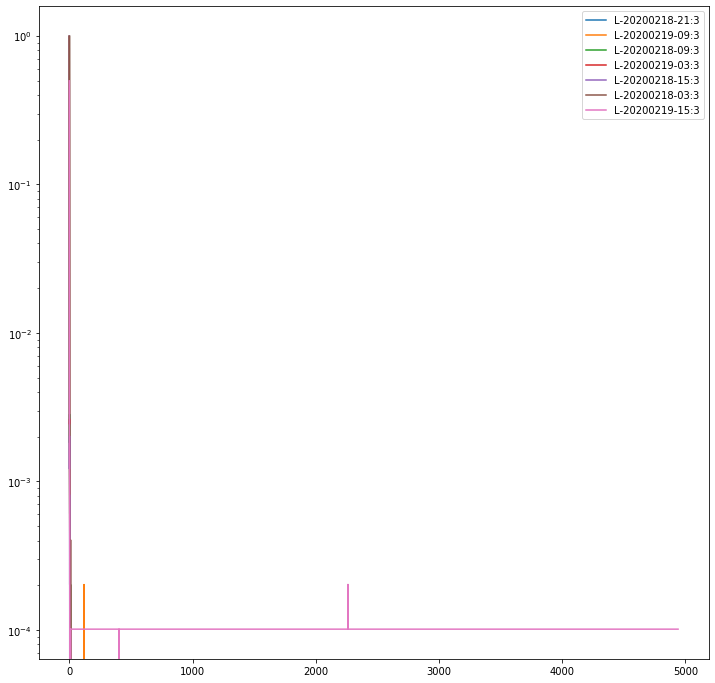

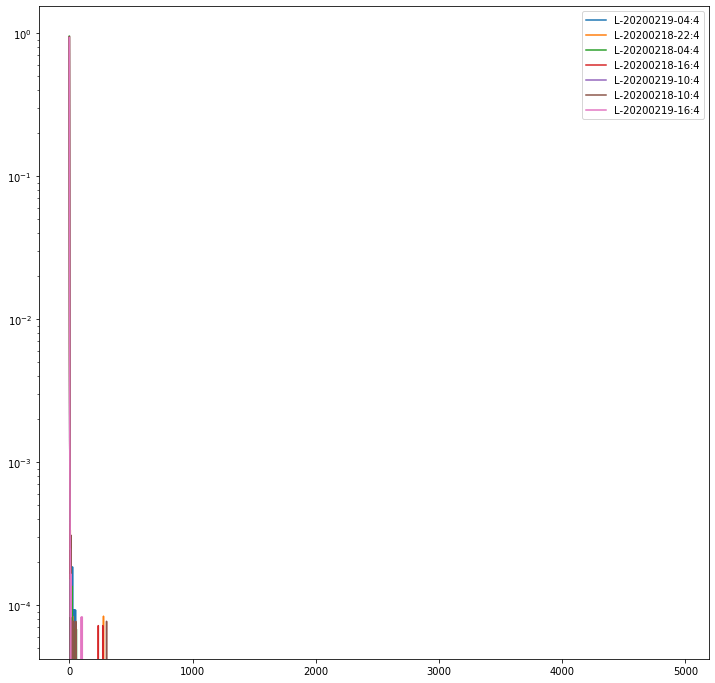

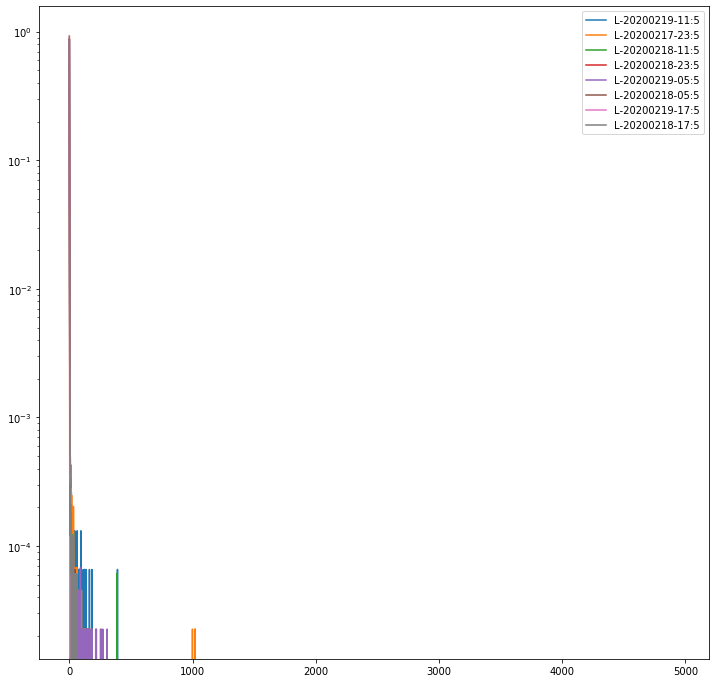

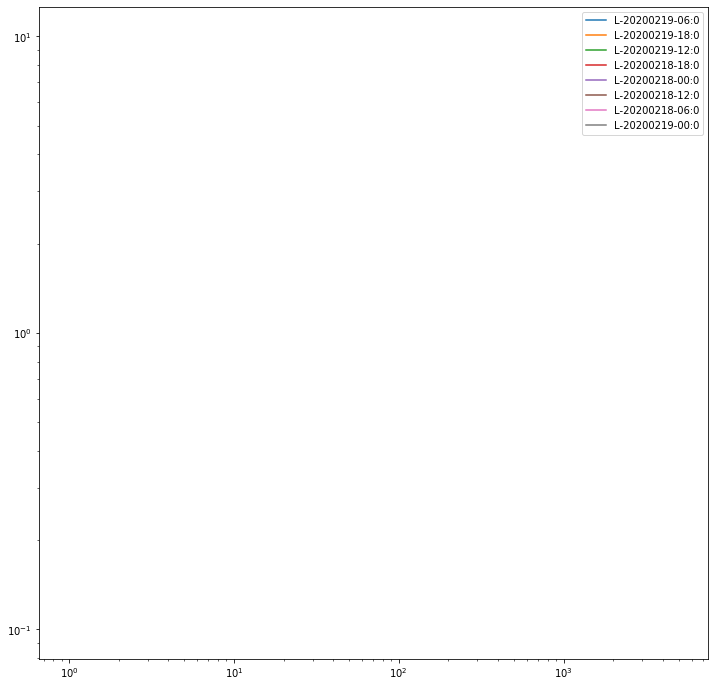

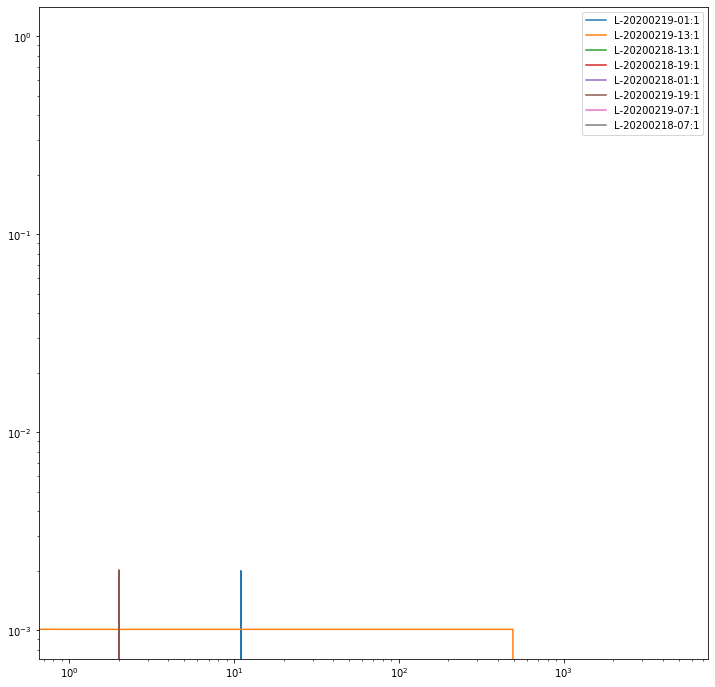

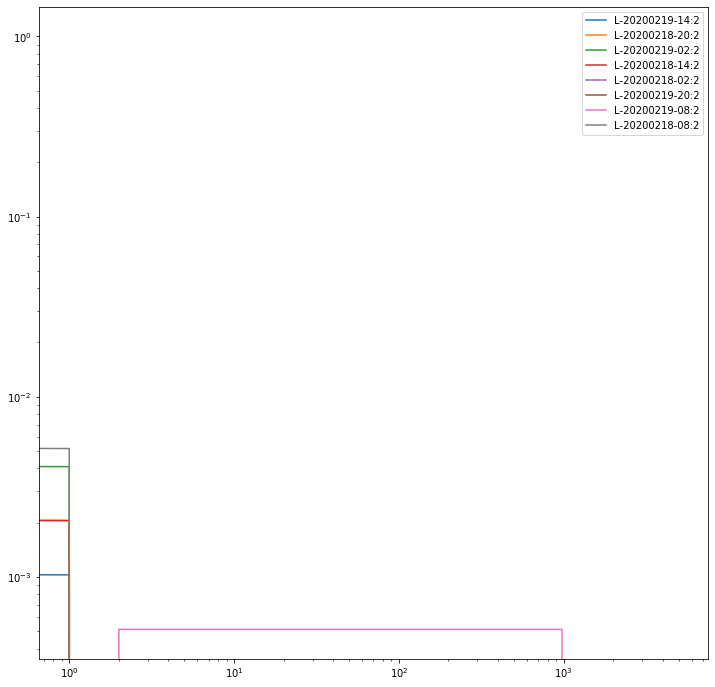

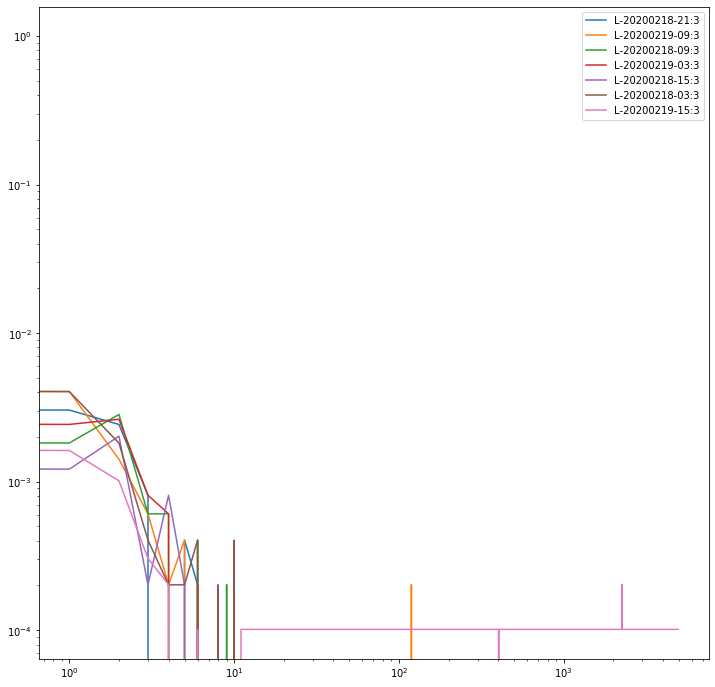

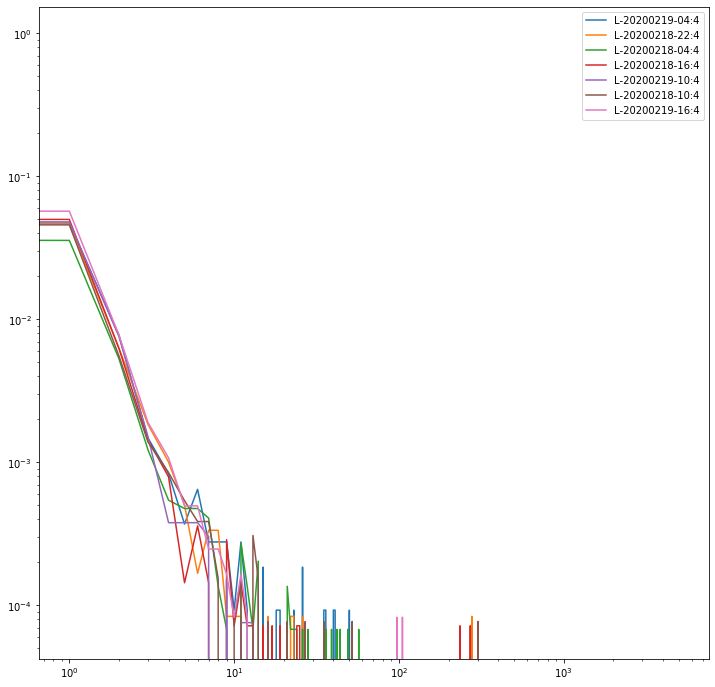

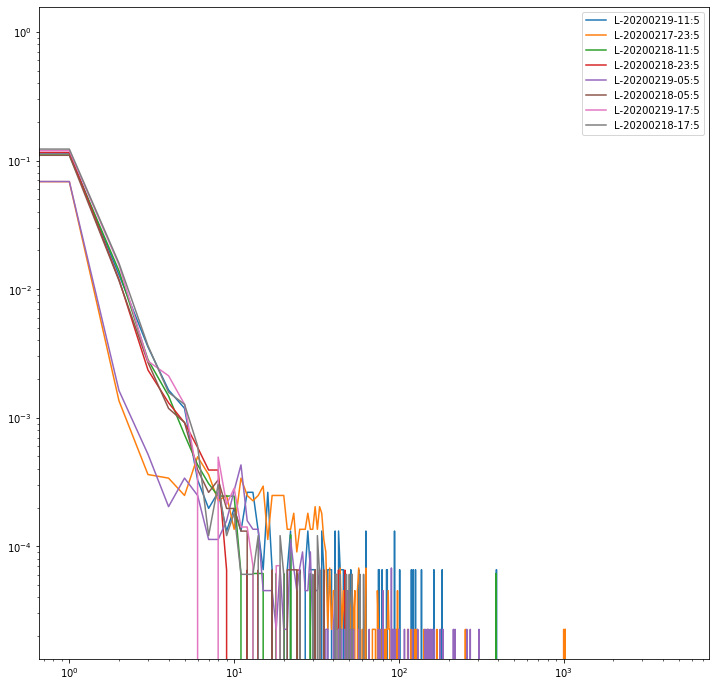

In [225]:
print("log axis on y")
for i in range(6):
    distributions_df.filter(regex=f":{i}").plot(logy=True, figsize=[12,12])

print("loglog axes, showing exponential values better")
for i in range(6):
    distributions_df.filter(regex=f":{i}").plot(loglog=True, figsize=[12,12])
